In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [43]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data = np.array(data)

In [45]:
# getting the dimensions of the data,
# where, m = nrows, n = ncols + 1 (labels' column)
m, n = data.shape

print(f'm = {m}\nn = {n}')

m = 42000
n = 785


In [46]:
# shuffling the data before splitting it into dev and training sets
# this is done to avoid systematic errors
np.random.shuffle(data)

The dev is essentially the test_set( train.csv ) : a part of the data that you keep aside to avoid overfitting, as you always run the risk of obtaining a super accurate model, at the cost of it not being generalized to the data you actually want it to be generalized to.

In [47]:
# dev set
# taking the first 1000 images
data_dev = data[0:1000].T

# first row (this is the labels' column)
Y_dev = data_dev[0]

# the remaining rows
X_dev = data_dev[1 : n]

# normalizing the elements
X_dev = X_dev / 255.

In [48]:
# train set
# taking the remaining images
data_train = data[1000:m].T

Y_train = data_train[0]
X_train = data_train[1:n]

X_train = X_train / 255.

In [49]:
X_train.shape

(784, 41000)

In [50]:
Y_train

array([0, 3, 4, ..., 0, 0, 3])

**The key differences between the two functions:**

**Distribution:** The first uses np.random.rand to draw from a uniform distribution between 0 and 1, 

while the second line uses np.random.normal to draw from a normal (Gaussian) distribution with mean=0 and standard deviation=1.

**Scaling:** The first line subtracts 0.5 to center the values around 0,

while the second line multiplies by np.sqrt(1./(784))
to scale the values down based on the input size (784).

**The Xavier/Glorot initialization is generally preferred over the uniform initialization for initializing weights in deep neural networks, as it can lead to better convergence and performance.**

In [51]:
'''
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2
'''
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    
    return W1, b1, W2, b2

**"Xavier initialization" or "Glorot initialization"**

np.random.normal(size=(10, 784)) **creates a numpy array of shape (10, 784)**,

**filled with random numbers drawn from a standard normal distribution** (Gaussian distribution with mean=0 and standard deviation=1).

np.sqrt(1./(784)) **calculates the square root of 1 divided by 784**. This value is used for **scaling the random numbers drawn from the normal distribution**.

The random numbers from the standard normal distribution are **multiplied by np.sqrt(1./(784))**, **which scales them down by a factor of sqrt(1/784)** or **approximately 0.0354.**

In [52]:
# Z if (Z > 0), 0 if (Z <= 0)
def ReLU(Z):
    return np.maximum(Z, 0)

# 1 if (Z > 0), 0 if (Z <= 0)
def ReLU_deriv(Z):
    return Z > 0

# the derivative function works because when booleans are converted to numbers,
# True converts to 1 and False converts to 0
# So, if Z > 0 it returns 1 else 0

In [53]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [54]:
def one_hot(Y):
    # creates another matrix with 0s of size m, n (+ 1 as .max will return n-1)
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    
    # for each row, go to col specified by the label in Y and set it to 1
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    # transpose as we want it to be in the form of a col
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

In [55]:
def forward_prop(W1, b1, W2, b2, X):
    
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [56]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2

In [57]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1 
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2  
    
    return W1, b1, W2, b2

In [58]:
def get_predictions(A2):
    # this is basically retrieving the index of the largest number (probability)
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

# np.sum(predictions==Y) calculates,
# the number of elements where the prediction matches the true label,
# Y.size gives us the total size of the array (Y_train)

In [59]:
def gradient_descent(X, Y, alpha, iterations):
    
    W1, b1, W2, b2 = init_params()
    
    for i in range(iterations):
        
        # FORWARD PROPOGATION
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        
        # BACKWARD PROPOGATION
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        # PARAMETER UPDATES
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Checking the accuracy of the model every tenth iteration
        if i % 10 == 0:
            print(f'\nIteration = {i}\n')
            
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            
    return W1, b1, W2, b2

In [60]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 200)


Iteration = 0

0.09839024390243903

Iteration = 10

0.13809756097560977

Iteration = 20

0.21285365853658536

Iteration = 30

0.29909756097560974

Iteration = 40

0.42560975609756097

Iteration = 50

0.5435365853658537

Iteration = 60

0.6395365853658537

Iteration = 70

0.7521219512195122

Iteration = 80

0.7956341463414635

Iteration = 90

0.8132926829268292

Iteration = 100

0.8261463414634146

Iteration = 110

0.8355609756097561

Iteration = 120

0.8434146341463414

Iteration = 130

0.849170731707317

Iteration = 140

0.8547317073170732

Iteration = 150

0.8592682926829268

Iteration = 160

0.8635609756097561

Iteration = 170

0.8669024390243902

Iteration = 180

0.8697317073170732

Iteration = 190

0.8730243902439024


In [61]:
def make_predictions(X, W1, b1, W2, b2):
    
    # as we have the final weights and biases,
    # we can directly use forward propogation to test things out
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    
    current_image = X_train[:, index, None]
    
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    
    # retrieve the actual value
    label = Y_train[index]
    
    print(f'\nPrediction = {prediction}')
    print(f'Label = {label}')
    
    # reshape the array into a matrix of 28x28 to form the image
    # undo the normalization performed with * 255
    current_image = current_image.reshape((28, 28)) * 255
    
    # plot the image
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


Prediction = [0]
Label = 0


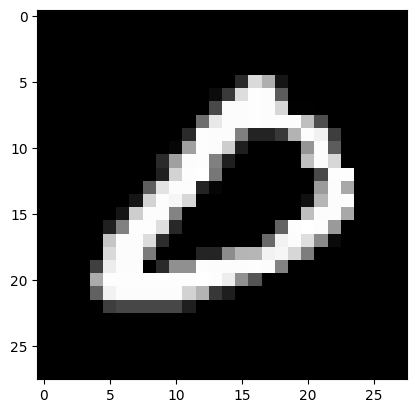


Prediction = [3]
Label = 3


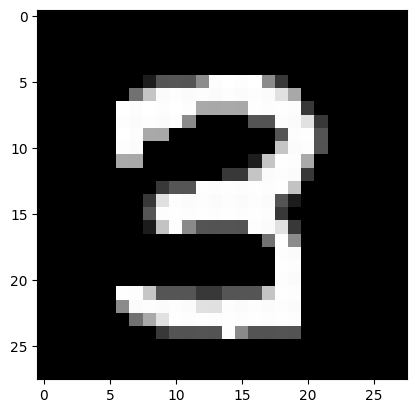


Prediction = [4]
Label = 4


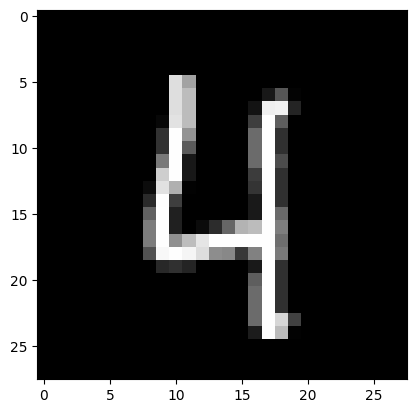


Prediction = [6]
Label = 6


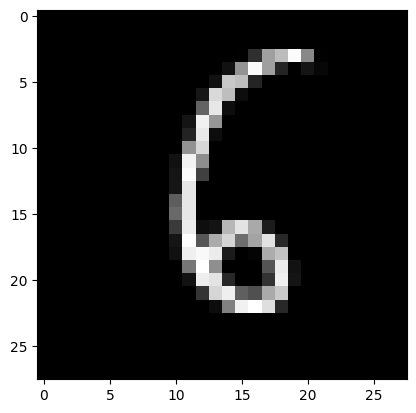

In [62]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [63]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)

final_accuracy = get_accuracy(dev_predictions, Y_dev)

print(f'Model Accuracy = {final_accuracy * 100}')

Model Accuracy = 87.1
